# MovieLens 100k — Exploratory Data Analysis
Quick look at the dataset: rating distributions, user/item activity, and genre breakdown.

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Load data
DATA_PATH = os.path.join("..", "data", "ml-100k", "ml-100k")

# Ratings
ratings = []
with open(os.path.join(DATA_PATH, "u.data"), "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        ratings.append((int(parts[0]), int(parts[1]), float(parts[2]), int(parts[3])))

users_arr = np.array([r[0] for r in ratings])
items_arr = np.array([r[1] for r in ratings])
ratings_arr = np.array([r[2] for r in ratings])

print(f"Ratings:  {len(ratings):,}")
print(f"Users:    {len(set(users_arr)):,}")
print(f"Items:    {len(set(items_arr)):,}")
print(f"Sparsity: {1 - len(ratings) / (943 * 1682):.2%}")

Ratings:  100,000
Users:    943
Items:    1,682
Sparsity: 93.70%


## 1. Rating Distribution

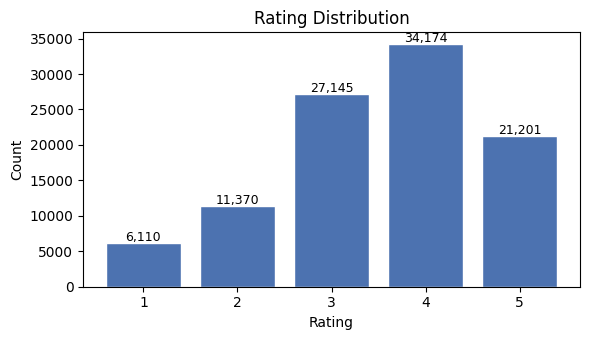

In [10]:
fig, ax = plt.subplots(figsize=(6, 3.5))
counts = Counter(ratings_arr)
xs = sorted(counts.keys())
ax.bar(xs, [counts[x] for x in xs], color="#4c72b0", edgecolor="white")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title("Rating Distribution")
ax.set_xticks([1, 2, 3, 4, 5])
for x in xs:
    ax.text(x, counts[x] + 300, f"{counts[x]:,}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

## 2. Ratings per User & per Item

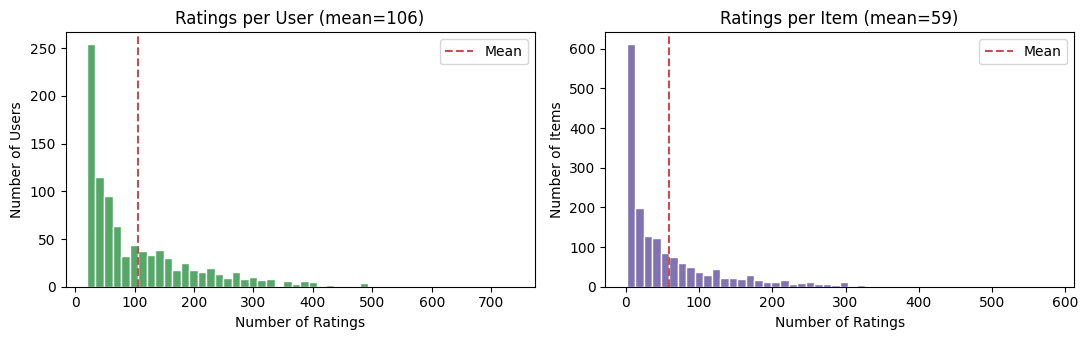

In [11]:
user_counts = Counter(users_arr)
item_counts = Counter(items_arr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3.5))

ax1.hist(user_counts.values(), bins=50, color="#55a868", edgecolor="white")
ax1.set_xlabel("Number of Ratings")
ax1.set_ylabel("Number of Users")
ax1.set_title(f"Ratings per User (mean={np.mean(list(user_counts.values())):.0f})")
ax1.axvline(np.mean(list(user_counts.values())), color="#c44e52", ls="--", label="Mean")
ax1.legend()

ax2.hist(item_counts.values(), bins=50, color="#8172b2", edgecolor="white")
ax2.set_xlabel("Number of Ratings")
ax2.set_ylabel("Number of Items")
ax2.set_title(f"Ratings per Item (mean={np.mean(list(item_counts.values())):.0f})")
ax2.axvline(np.mean(list(item_counts.values())), color="#c44e52", ls="--", label="Mean")
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Most Rated Movies

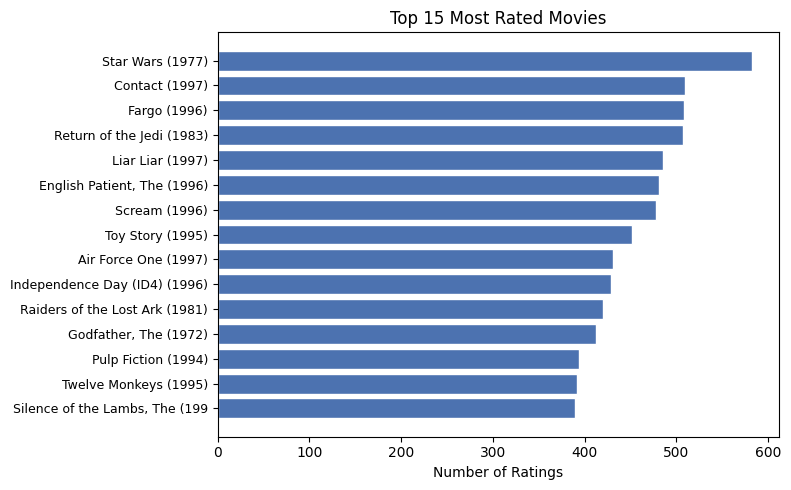

In [12]:
# Load movie titles
titles = {}
with open(os.path.join(DATA_PATH, "u.item"), "r", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split("|")
        titles[int(parts[0])] = parts[1]

# Top 15 most rated
top15 = item_counts.most_common(15)
names = [titles[iid][:30] for iid, _ in top15]
counts_vals = [c for _, c in top15]

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(range(14, -1, -1), counts_vals, color="#4c72b0", edgecolor="white")
ax.set_yticks(range(14, -1, -1))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel("Number of Ratings")
ax.set_title("Top 15 Most Rated Movies")
plt.tight_layout()
plt.show()

## 4. Genre Breakdown

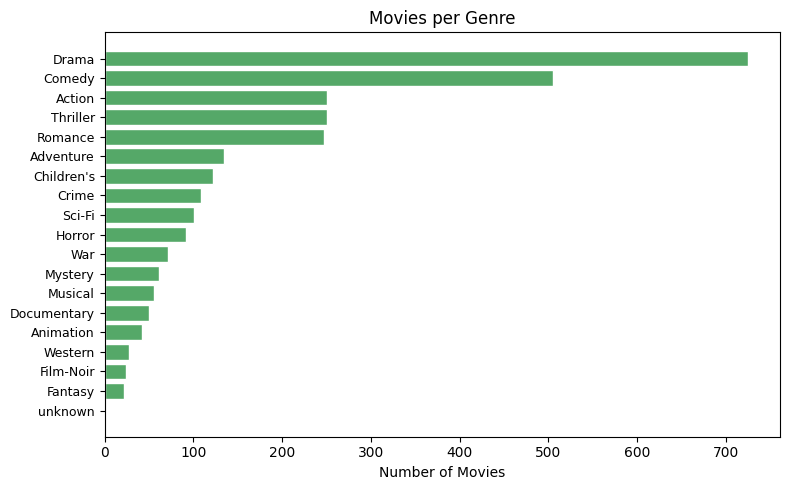

In [13]:
# Load genre names
genre_names = []
with open(os.path.join(DATA_PATH, "u.genre"), "r") as f:
    for line in f:
        if "|" in line:
            genre_names.append(line.strip().split("|")[0])

# Count movies per genre from u.item (columns 5-23 are genre flags)
genre_counts = {g: 0 for g in genre_names}
with open(os.path.join(DATA_PATH, "u.item"), "r", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split("|")
        flags = parts[5:]  # 19 genre binary flags
        for i, flag in enumerate(flags):
            if i < len(genre_names) and flag == "1":
                genre_counts[genre_names[i]] += 1

# Sort and plot
sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
g_names = [g for g, _ in sorted_genres]
g_vals = [c for _, c in sorted_genres]

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(range(len(g_names)-1, -1, -1), g_vals, color="#55a868", edgecolor="white")
ax.set_yticks(range(len(g_names)-1, -1, -1))
ax.set_yticklabels(g_names, fontsize=9)
ax.set_xlabel("Number of Movies")
ax.set_title("Movies per Genre")
plt.tight_layout()
plt.show()

## 5. Average Rating by Genre

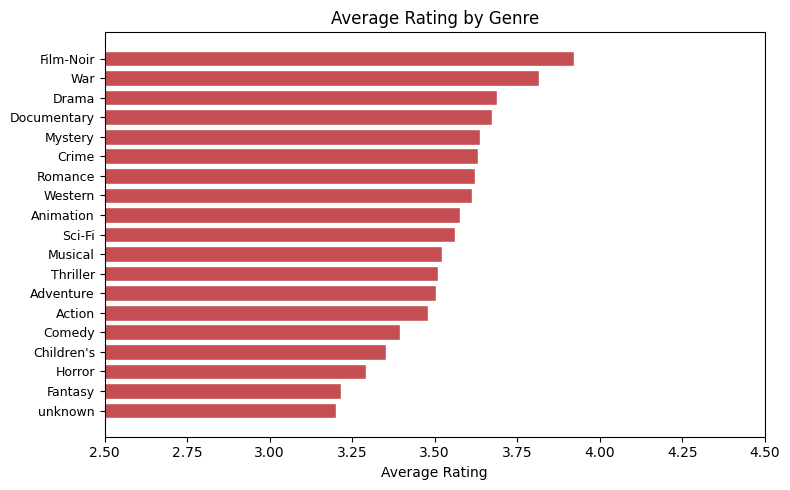

In [14]:
# Build item→genres mapping
item_genres = {}
with open(os.path.join(DATA_PATH, "u.item"), "r", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split("|")
        iid = int(parts[0])
        flags = parts[5:]
        item_genres[iid] = [genre_names[i] for i, fl in enumerate(flags) if i < len(genre_names) and fl == "1"]

# Accumulate ratings per genre (user/item IDs in u.data are 1-indexed)
genre_rating_sum = {g: 0.0 for g in genre_names}
genre_rating_cnt = {g: 0 for g in genre_names}
for _, iid, r, _ in ratings:
    for g in item_genres.get(iid, []):
        genre_rating_sum[g] += r
        genre_rating_cnt[g] += 1

avg_by_genre = {g: genre_rating_sum[g] / genre_rating_cnt[g]
                for g in genre_names if genre_rating_cnt[g] > 0}
sorted_avg = sorted(avg_by_genre.items(), key=lambda x: x[1], reverse=True)

g_names2 = [g for g, _ in sorted_avg]
g_avgs = [v for _, v in sorted_avg]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(range(len(g_names2)-1, -1, -1), g_avgs, color="#c44e52", edgecolor="white")
ax.set_yticks(range(len(g_names2)-1, -1, -1))
ax.set_yticklabels(g_names2, fontsize=9)
ax.set_xlabel("Average Rating")
ax.set_title("Average Rating by Genre")
ax.set_xlim(2.5, 4.5)
plt.tight_layout()
plt.show()

## Key Takeaways

- The dataset is **very sparse** (~93.7% of user–item pairs have no rating).
- Rating **4** is the most common; users lean positive on average.
- A small number of blockbuster movies receive a disproportionate share of ratings.
- **Drama** and **Comedy** dominate the catalogue, while niche genres like **Fantasy** and **Film-Noir** have few entries.
- Genre-level average ratings are tightly clustered (≈3.1–3.8), suggesting genre alone is a weak predictor — collaborative filtering captures finer signal.